In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 2
### 1. 
use the rate given by equation 2.1 with $r_0$ = 50Hz and
$$
D(\tau) = -\cos(\frac{2\pi(\tau - 20 \text{ms} )}{140\text{ms}})\exp(-\frac{\tau}{60\text{ms}}) \text{Hz/ms}
$$

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus
- above equation is an approximation for the linear kernel obtained from the STA in fig 1.9
- use approximate gaussian white noise stimulus constructed by choosing stimulus values at every 10ms ($\delta t$ = 10ms)
    - from gaussian distribution with zero mean and variance $\sigma^2_s / \delta t$ with $\sigma_s^2 = 10$
- compute firing rate over 10s  period
- from results, compare firing rate-stimulus correlation function $Q_{rs}(\tau)$ 
- using equation 2.6, compare $Q_{rs}(-\tau)/\sigma^2_s$ with kernel $D(\tau)$ given above

equation 2.1:
$r_{est}(t) = r_0 + \int_0^\infty d\tau D(\tau)s(t-\tau) $

equation 2.6:
$ D(\tau) = \frac{Q_{rs}(-\tau)}{\sigma^2_s} = \frac{\langle r \rangle C(\tau)}{\sigma^2_s} $

In [13]:
r0 = 50
dt = 10e-3
t = np.arange(0, 10, dt)
noise_std = np.sqrt(10/dt)
s = np.random.normal(0, noise_std, len(t))
kernel = -np.cos((2 * np.pi * (t - 20e-3)) / 140e-3) * np.exp(-t / 60e-3)

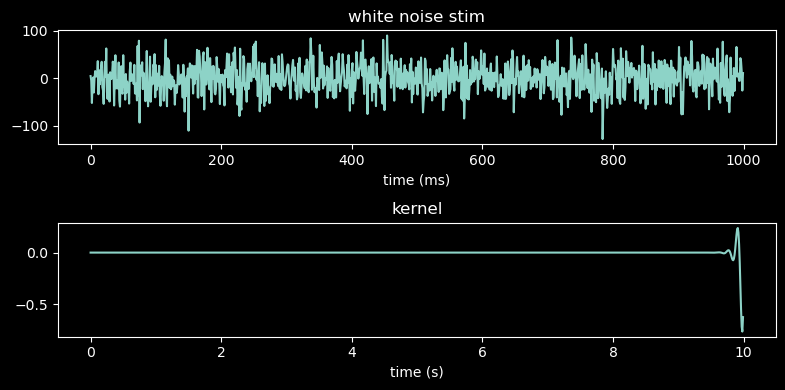

In [14]:
# check stimulus and kernel
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].plot(s)
ax[0].set_title('white noise stim')
ax[0].set_xlabel('time (ms)')
ax[1].plot(t[::-1], kernel)
ax[1].set_title('kernel')
ax[1].set_xlabel('time (s)')

plt.tight_layout()

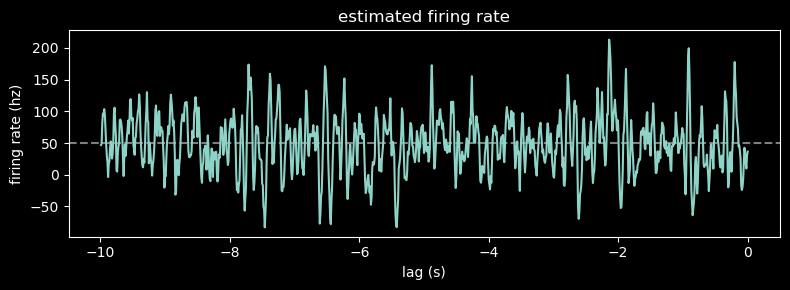

In [15]:
convolved = np.convolve(kernel, s, mode='full') + r0
lags = np.arange(-len(kernel)+1, len(kernel))*dt

fig, ax = plt.subplots(figsize=(8, 3))
ax.axhline(50, label='background firing rate', linestyle='--', alpha=0.5)
ax.plot(lags[:(int(np.ceil(len(lags)/2)))], convolved[:int(np.ceil(len(lags)/2))])
ax.set_title('estimated firing rate')
ax.set_xlabel('lag (s)')
ax.set_ylabel('firing rate (hz)')
plt.tight_layout()

In [16]:
# firing rate-stim autocorrelation 
r_est = convolved[:int(np.ceil(len(lags)/2))]
autocorr = np.correlate(s, r_est, mode='full') / (len(t))
autocorr = autocorr[:int(np.ceil(len(autocorr) / 2))] / noise_std**2

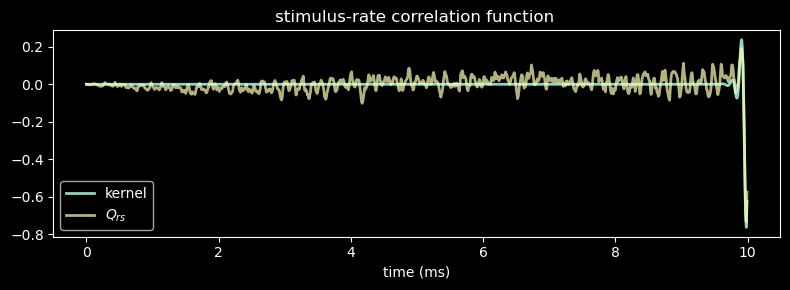

In [17]:
# good fit b/w kernel estimate and empirical autocorrelation! just noisier
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t[::-1], kernel, label='kernel', linewidth=2)
ax.plot(t[::-1], autocorr[::-1], label='$Q_{rs}$', alpha=0.7, linewidth=2)
ax.set_title('stimulus-rate correlation function ')
ax.set_xlabel('time (ms)')
ax.legend()
plt.tight_layout()

### 2
use STA computed in c1p8 to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron
- choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate
- use a poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus `stim`
- plot examples of the actual and synthetic spike trains
    - how are they similar / different?
- plot autocorrelation function of actual and synthetic spike trains over range 0-100ms
    - why is there a dip at a lag of 2ms in the autocorrelation of the actual spike traim?
    - is there a dip for the synthetic train too?
- plot the ISI histogram for both spike trains
    - why is there a dip below 6ms in the actual spike train histogram?
- what are the coefficients of variation for the two spike trains and why might they differ?

In [18]:
# doing c1p8 STA again here
h1_data = pd.read_csv('C1P8.csv', header=None)
h1_data.rename(columns={0:'rho', 1:'stim'}, inplace=True)

dt8 = 2e-3
window_size = 300e-3

def get_sta(data, window_size, dt):
    window_steps = int(window_size/dt)
    sta_sum = np.zeros(window_steps)
    num_spikes = np.sum(data['rho'])
    # loop through spike train
    for i in range(window_steps, len(data['rho'])):
        # spike
        if data['rho'][i] == 1:
            # add preceding stimulus to spike-triggered sum
            sta_sum += np.asarray(data['stim'][i - window_steps:i])
    # get average of spike-triggered sum
    return sta_sum / num_spikes

sta8 = get_sta(h1_data, window_size, dt8)

In [81]:
stim_var = np.var(h1_data['stim'])
stim_mean = np.mean(h1_data['stim'])
spike_mean = np.mean(h1_data['rho']) / dt8 # Hz

equation 2.1:
$r_{est}(t) = r_0 + \int_0^\infty d\tau D(\tau)s(t-\tau) $

equation 2.6:
$ D(\tau) = \frac{Q_{rs}(-\tau)}{\sigma^2_s} = \frac{\langle r \rangle C(\tau)}{\sigma^2_s} $

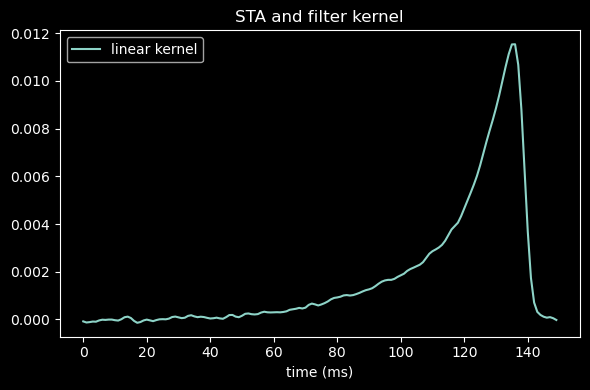

In [85]:
# pretend xticks are negative time
kernel8 = sta8 / stim_var
fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(sta8, label='h1 STA')
ax.plot(kernel8, label='linear kernel')
ax.set_title('STA and filter kernel')
ax.set_xlabel('time (ms)')
ax.legend()
plt.tight_layout()

In [123]:
r_est = np.convolve(h1_data['stim'], kernel8[::-1], mode='same')
np.mean(r_est) # want this to be ~44

-0.025550816171337754

In [124]:
#r_est += 45
syn_data = np.random.poisson(r_est * dt8)
syn_data[syn_data > 1] = 1

In [125]:
syn_times = np.where(syn_data)[0]
h1_times = np.where(h1_data['rho'])[0]

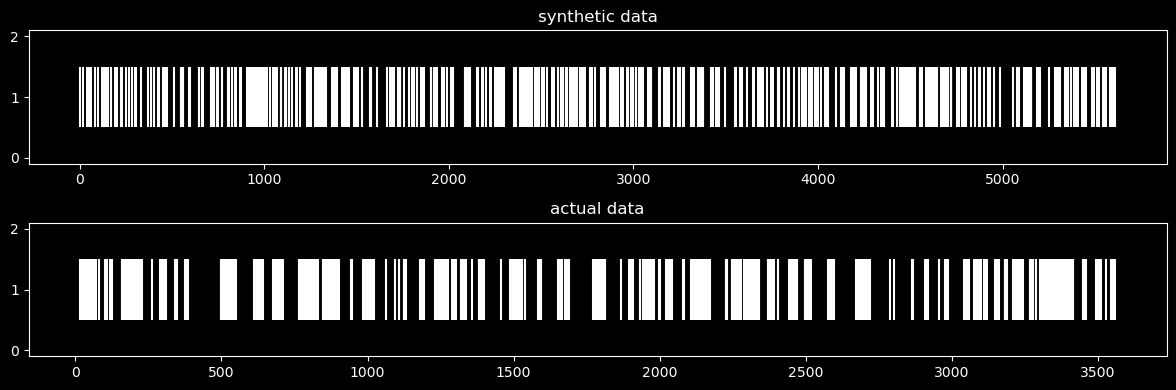

In [140]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
ax[0].eventplot(syn_times[:500])
ax[0].set_title('synthetic data')
ax[1].eventplot(h1_times[:500])
ax[1].set_title('actual data')
plt.tight_layout()